In [1]:
import sys
print("python version: ", sys.version)

import pandas as pd
print("pandas version: ", pd.__version__)

import numpy as np
print('numpy version: ', np.__version__)

import scipy as sp
print('scipy version: ', sp.__version__)

import sklearn as skl
print('sklearn version: ', skl.__version__)

import matplotlib.pyplot as plt

import seaborn as sns

import keras as ks
print('keras version: ', ks.__version__)
print('keras backend: ', ks.backend.backend())

import tensorflow as tf
print('tensorflow version: ', tf.__version__)

import theano as th
print('theano version: ', th.__version__)

import warnings
warnings.filterwarnings('ignore')


from keras import backend as K
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_recall_curve

import os
import random

('python version: ', '2.7.15 |Anaconda, Inc.| (default, Dec 14 2018, 19:04:19) \n[GCC 7.3.0]')
('pandas version: ', u'0.23.4')
('numpy version: ', '1.15.4')
('scipy version: ', '1.1.0')
('sklearn version: ', '0.19.2')


Using TensorFlow backend.


('keras version: ', '2.1.6')
('keras backend: ', u'tensorflow')
('tensorflow version: ', '1.10.0')
('theano version: ', '0.8.2')


In [2]:
def set_keras_backend(backend):
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

set_keras_backend("tensorflow")

In [3]:
excel_file = r'geriomop-data-from-egems-paper-UPDATED-COL-FIX-ATC_2-and-behavior-change-022819.tsv'
df = pd.DataFrame(pd.read_csv(excel_file, sep='\t'))
print(df.shape)

(7584, 208)


In [4]:
# Get atc codes
atc_list = []
for i in range(1, 6):
    atc_list.append(df.groupby('atc_%d' % i)['min_effective_dose_%d' % i].first())
atc_codes = pd.concat(atc_list)
atc_codes = atc_codes[~atc_codes.index.duplicated()].index.tolist()

# Fill missing min_effective_dose
atc_dic = [('N03AE01', 0.5), ('N05AB04', 15), ('N05AX13', 3), ('N05CD04', 1), ('N06AX21', 60), ('N06AX24', 20), \
           ('N06AX23', 50)]
for code, dose in atc_dic:
    for i in range(1, 6):
        df.loc[df['atc_%d' % i] == code, 'psych_sdd_%d' % i] = \
            df.loc[df['atc_%d' % i] == code, 'Psychotropic-%d-average-daily-dose' % i] / dose

# Set sdd=0 to NA
for i in range(1, 6):
    df.loc[df['psych_sdd_%d' % i] == 0, 'psych_sdd_%d' % i] = np.nan

# Missing value means not relevant
### One Hot Encoding (All zero stands for NA)
* "Mds-fall-2-6-months-to-admission", "Mds-fall-last-month-to-admission", "mds-pain-last-five-days" (Y/N/U/NA)
* "mds-long-term-memory-ok", "mds-short-term-memory-ok", "mds-staff-assess-pain", "mds-delirium-scale", "recent-start-other-fall-risk-rx" (Y/N/NA)
* "mds-pressure-ulcer-stage-X", (X=1, 2, 3, 4) (Y/NA)

### Label Encoding & Sin, Cos Transform (NA: (0, 0))
* "mds-cognitive-scale": 
  - 'Independent': 0, 
  - 'Modified Independence': 1, 
  - 'Moderately Impaired': 2, 
  - 'Severely Impaired': 3
* "mds-pain-freq-last-five-days": 
  - 'Continuous': 4, 
  - 'Frequent': 3, 
  - 'Occasional': 2, 
  - 'Rare': 1, 
  - 'Unable to respond': 0,
* "mds-pain-intensity": 
  - 'None': 0, 
  - 'Mild': 1, 
  - 'Moderate': 2, 
  - 'Severe': 3, 
  - 'Very severe, horrible': 4
* "Psychotropic-X": Number
* (Added) "Psychotropic-X-Period": Number


# Drop features

* ~~"Unnamed: 51"~~, 
* ~~"pk-interaction", "pk-interaction-type"~~ 
* ~~"object-drug-1", "object-drug-1-dose", "object-drug-1-effective-dose-increase", "object-drug-1-effective-dose", "interaction-1-stop-date"~~, 
* ~~"object-drug-2", "object-drug-2-dose", "object-drug-2-effective-dose-increase", "object-drug-2-effective-dose", "interaction-2-stop-date"~~
* "ws-sudden-stop", "ws-sudden-stop-drugs", "ws-prolonged-psychotropics", "mds-toilet-prgm-atmptd"
* "Blank-1", "Deleted-X" (X from 1 to 12), "Psychotropic-X-average-daily-dose", "Psychotropic-X-Start/End-date"
* "Entry-discharge-type"

# Encode features (originally) with no missing values

### Date-related Transform

* episodePeriod = episode-end-date - episode-start-date
* stayPeriod = stay-end-date - stay-start-date

### Drop Date-related Features

* "episode-start-date", "episode-end-date", "stay-start-date", "stay-end-date", "predictor-date", "projected-date"

### Binary Encoding (Y/N)

* "cms-long-stay", "mds-stay-trans-short-to-long",
* "mds-antianxiety-medication", "mds-antidepressant-medication", "mds-antipsychotic-medication", "mds-antibiotic-medication",
* "mds-anticoagulant-medication", "mds-diuretic-medication", "mds-hypnotic-medication",
* "mds-behavioral-symptoms", "mds-behavioral-symptoms-to-others", "mds-dehydrated", "mds-depression", "mds-fever",
* "mds-impaired-mobility", "mds-impaired-transfer", "mds-internal-bleeding", "mds-malnutrition", "mds-no-problem-conditions",
* "mds-vomiting", "mds-impaired-walk-in-room", "mds-impaired-walk-in-corridor", "mds-impaired-locomot-unit", "mds-impaired-locomot-other",
* "ws-antibiotic-anticoag-coexposure",
* "ws-psychotropic-with-not-ordered-weight-loss", "ws-diuretic-adl"

### One Hot Encoding

* "race", "facility", "gender", "mds-bims-summary-ranking", "ws-meclizine-psych-coexposure", 

### Drop Feature
* "PPS-assessment", "Federal-assessment"

### Mapping

* mds-pain-non-verbal {'None/Mild':0,'Moderate/Severe':1}

# Features need imputation
### One Hot Encoding

1. Binary categories (Yes/No/NA)
   * "pneumonia", "uti", "mdro", "anemia", "septicemia", "constipation", 
   * "wound", "hyponatremia", "hyperkalemia", "embolisms", 
   * "alzheimers", "anxiety", "depression", "non-alz-dimentia", 
   * "bipolar", "parkinsons", "psychosis", "schizophrenia", "seizure", "aphasia", "emphysema", 
   * "arthritis", "ashd", "bph", "cancer", "cerebralpalsy", "stroke", "cirrhosis", "comatose", 
   * "diabetes", "dysrhythmias", "gerd", "heart-failure", "hemiplegia/hemiparesis", "hepatitis", 
   * "huntingtons", "hyperlipidemia", "hyperthyroidism", "hypothyroidism", "hypertension", 
   * "hypotension", "multiple-sclerosis", "neurogenic-bladder", "obstructive-uropathy", 
   * "osteoporosis", "paraplegia", "ptsd", "pvd", "quadriplegia", "thyroid-disorder", 
   * "tourettes", "transient-ischemic-attack", "traumatic-brain-injury", "tuberculosis", "renal-failure", 

   * "mds-delirium-scale", "mds-pain-medication", "mds-received-pain-tx-non-pharm ", "mds-received-prn-pain-medication",
   * "mds-conduct-staff-assessment-mental-status", "mds-pressure-ulcer-prsnt", "conduct_bims", "acute_mental_change",
   * "conduct_pain_assmnt", "cane_or_crutch_past_7_days", "walker_past_7_days", "wheelchair_past_7_days", 
   * "limb_prosthesis_past_7_days", "no_listed_mobility_device", 


2. Other categories

   * "marital-status": 
     - "Never Married", "Married", "Widowed", "Separated", "Divorced"
   * "mds-entered-from": 
     - "Acute Hospital", "Psychiatric Hospital", "Another nursing home or swing bed", "Hospice", "Inpatient rehabilitation facility"
     - "Community (private home/apt., board/care, assisted living, group home)",  "Other", 
   * "mds-excess-weight-loss": 
     - "Yes - prescribed", "Yes - not prescribed", "No or unknown"
   * "balance_while_standing", "balance_while_walking", "balance_turning_around", "balance_toileting", "balance_bed_to_chair"
     - "Steady at all times", "able to stabilize without assistance", "able to stabilize with assistance", "Activity did not occur"
    
### Label Encoding
* "mds-urinary-incontinence"
  - "Always continent": 0, 
  - "Occasionally incontinent": 1,
  - "Frequently incontinent": 2,
  - "Always incontinent": 3,
  - "Catheter - not rated": (0, 0)


* "cam_inattention",
* "cam_disorganized_thought",
* "cam_altered_conc",
* "cam_motor_retardation"
  - "Behavior not present": 0,
  - "Behavior present, fluctuates": 1, 
  - "Behavior continuously present": 2, 

   
* "functlimit_rom_upper", 
* "functlimit_rom_lower"
   - "No impairment": 0, 
   - "Impairment on one side": 1, 
   - "Impairment on both sides": 2 


* "does_resident_wander"
   - "Behavior not exhibited": 0, 
   - "1 to 3 days": 1, 
   - "4 to 6 days": 2, 
   - "occurred daily": 3,

# Features from new dataset
* "atc_X" (X from 1 to 5) - one hot encoding
* "number_of_behavior_changes" - keep
* "min_effective_dose_X" - drop
* "psych_sdd_X" - sin/cos transform

In [5]:
# drop feature
def drop_features(df, f):
    df.drop(f, axis=1, inplace=True)

In [6]:
# one hot encoding
def one_hot_encoding(df, features, categories):
    for f, c in zip(features, categories):
        df[f] = df[f].astype('category', categories=c)
    return pd.get_dummies(df, columns=features, prefix=features)

In [7]:
# compute date difference
def date_diff(start, end):
    return (pd.to_datetime(end) - pd.to_datetime(start)) / np.timedelta64(1, 'D')

In [8]:
# generate date diff features
def generate_period(df, f):
    for start, end, period in f:
        df[period] = date_diff(df[start], df[end])
        df.drop([start, end], axis=1, inplace=True)

In [9]:
# label encoding
def label_encoding(df, features, dictionaries):
    for f, dic in zip(features, dictionaries):
        df[f] = df[f].map(dic)

In [10]:
# sin&cos transform
def col_transform(df, col, mmax, mmin, df_ref=None):
    if(mmax <= mmin):
        # for test set, if max&min not set, use training set value
        if(df_ref is not None): 
            mmax = df_ref[col].max()
            mmin = df_ref[col].max()
        else:
            mmax = df[col].max()
            mmin = df[col].min()
    angle = 0.25 * np.pi * (df[col] - mmin) / (mmax - mmin) + 0.125 * np.pi
    return (np.cos(angle), np.sin(angle))

def df_transform(df, f, df_ref=None):
    for col, mmax, mmin in f:
        df[col + '_x'], df[col + '_y'] = col_transform(df, col, mmax, mmin, df_ref)
        df[col + '_x'].fillna(0, inplace=True)
        df[col + '_y'].fillna(0, inplace=True)
        df.drop(col, axis=1, inplace=True)

In [11]:
# train test split
from sklearn.model_selection import GroupShuffleSplit
def train_test_split(df, target, groupby, radio, random_state):
    train_idx, test_idx = GroupShuffleSplit(train_size=radio, random_state=random_state).split(df, target, df[groupby]).next()
    return df.iloc[train_idx], df.iloc[test_idx], target.iloc[train_idx], target.iloc[test_idx]

In [12]:
# missing data describe
def missing_summary(df):
    missing_cnt = df.isna().sum()
    missing_data = pd.concat([missing_cnt, missing_cnt/df.shape[0]], axis=1, keys=['count', 'percentage'])
    return missing_data[missing_data['percentage'] != 0].sort_values(by='percentage', ascending=False)

In [13]:
# Drop features
f_drop = ["Blank-1", "ws-sudden-stop", "ws-sudden-stop-drugs", "ws-prolonged-psychotropics", "mds-toilet-prgm-atmptd"] + \
         ['Deleted-%d' % i for i in range(1, 13)] + ['Psychotropic-%d' % i for i in range(1, 6)] + \
         ['Psychotropic-%d-average-daily-dose' % i for i in range(1, 6)] + ["Entry-discharge-type"]

# Missing value means not relevant
f_one_hot = ["Mds-fall-2-6-months-to-admission", "Mds-fall-last-month-to-admission", "mds-pain-last-five-days", \
             "mds-delirium-scale", "mds-long-term-memory-ok", "mds-short-term-memory-ok", "mds-staff-assess-pain", \
             "recent-start-other-fall-risk-rx"] + ["mds-pressure-ulcer-stage-%d" % i for i in range(1, 5)]
cate_one_hot = [['Yes', 'No', 'Unable to answer']] * 3 + [['Yes', 'No']] * 9

f_period = [("Psychotropic-%d-Start-date" % i, 'Psychotropic-%d-End-date' % i, 'Psychotropic-%d-Period' % i) for i in range(1, 6)]

f_label = ['mds-cognitive-scale', 'mds-pain-freq-last-five-days', 'mds-pain-intensity']
dic_label = [{'Independent': 0, 'Modified Independence': 1, 'Moderately Impaired': 2, 'Severely Impaired': 3}, \
             {'Continuous': 4, 'Frequent': 3, 'Occasional': 2, 'Rare': 1, 'Unable to respond': 0}, \
             {'None': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Very severe, horrible': 4}]

f_transform = [('mds-cognitive-scale', 3, 0), ('mds-pain-freq-last-five-days', 4, 0), ('mds-pain-intensity', 4, 0)] + \
              [('Psychotropic-%d-Period' % i, 0, 0) for i in range(1, 6)]

In [14]:
# Encode features (originally) with no missing values
f_drop += ["predictor-date", "projected-date", "PPS-assessment", "Federal-assessment"]

f_period += [('episode-start-date', 'episode-end-date', 'episode-period'),\
             ('stay-start-date', 'stay-end-date', 'stay-period')]

f_label += ["cms-long-stay", "mds-stay-trans-short-to-long", "mds-antianxiety-medication", \
            "mds-antidepressant-medication", "mds-antipsychotic-medication", "mds-antibiotic-medication",
            "mds-anticoagulant-medication", "mds-diuretic-medication", \
            "mds-hypnotic-medication", "mds-behavioral-symptoms", "mds-behavioral-symptoms-to-others", \
            "mds-dehydrated", "mds-depression", "mds-fever", "mds-impaired-mobility", "mds-impaired-transfer", \
            "mds-internal-bleeding", "mds-malnutrition", "mds-no-problem-conditions", "mds-vomiting", \
            "mds-impaired-walk-in-room", "mds-impaired-walk-in-corridor", "mds-impaired-locomot-unit", \
            "mds-impaired-locomot-other", "ws-antibiotic-anticoag-coexposure", \
            "ws-psychotropic-with-not-ordered-weight-loss", \
            "ws-diuretic-adl", "ws-tramadol-antidepressant-coexposure"] + ["mds-pain-non-verbal"]
dic_label += [{'Yes': 1, 'No': 0}] * 28 + [{'None/Mild':0,'Moderate/Severe':1}]

f_one_hot += ["race", "facility", "gender", "mds-bims-summary-ranking", "ws-meclizine-psych-coexposure"]
cate_one_hot += [['White', 'Black', 'Other'], \
                 ['Sugar Creek', 'Heritage Place', 'Canterbury Place', 'Senaca Place', 'Cranberry Place'], \
                 ['Female', 'Male'], ['Intact or Moderately Intact', 'Moderate Impairment'], \
                 ['No', 'meclAndPsychStartSameR', 'meclPrecedesPsychR', 'psychPrecedesMeclR', 'meclAndPsychOlderStart']]

In [15]:
f_drop += ["min_effective_dose_%d" % i for i in range(1, 6)] + ["Psychotropic-%d-average-daily-dose" % i for i in range(1, 6)]

In [16]:
# generate target
target = df['outcome-Mds-fall-since-prior-assessment'].map({'None': 0, 'Yes': 1})
dff = df.drop(['outcome-mds-fall-no-injury', 'outcome-mds-fall-minor-injury', 'outcome-mds-fall-major-injury', \
               'outcome-Mds-fall-since-prior-assessment', 'outcome-riskmaster-fall-incident'], axis=1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(dff, target, 'patient-id', 0.7, 0)
print 'Total number of patients: %d' % len(df.groupby('patient-id'))
print 'Number of patients in training set: %d' % len(X_train.groupby('patient-id'))

Total number of patients: 3133
Number of patients in training set: 2193


In [18]:
%%time
generate_period(X_train, f_period)
label_encoding(X_train, f_label, dic_label)
X_train_original = X_train.copy() # store value range
df_transform(X_train, f_transform)
X_train = one_hot_encoding(X_train, f_one_hot, cate_one_hot)
drop_features(X_train, f_drop)

CPU times: user 14 s, sys: 72 ms, total: 14 s
Wall time: 31.8 s


In [19]:
X_train_use = X_train.copy()

In [20]:
print(X_train.dtypes[X_train.dtypes == 'object'].index)

Index([u'marital-status', u'mds-entered-from', u'mds-pain-medication',
       u'mds-received-pain-tx-non-pharm', u'mds-received-prn-pain-medication',
       u'mds-excess-weight-loss', u'mds-urinary-incontinence', u'pneumonia',
       u'uti', u'mdro', u'anemia', u'septicemia', u'constipation', u'wound',
       u'hyponatremia', u'hyperkalemia', u'embolisms', u'alzheimers',
       u'anxiety', u'depression', u'non-alz-dimentia', u'bipolar',
       u'parkinsons', u'psychosis', u'schizophrenia', u'seizure', u'aphasia',
       u'emphysema', u'arthritis', u'ashd', u'bph', u'cancer',
       u'cerebralpalsy', u'stroke', u'cirrhosis', u'comatose', u'diabetes',
       u'dysrhythmias', u'gerd', u'heart-failure', u'hemiplegia/hemiparesis',
       u'hepatitis', u'huntingtons', u'hyperlipidemia', u'hyperthyroidism',
       u'hypothyroidism', u'hypertension', u'hypotension',
       u'multiple-sclerosis', u'neurogenic-bladder', u'obstructive-uropathy',
       u'osteoporosis', u'paraplegia', u'ptsd', u'p

In [21]:
missing_summary(X_train_use)

,count,percentage
psych_sdd_5,5310,0.999812
atc_5,5276,0.993410
psych_sdd_4,5189,0.977029
atc_4,5151,0.969874
psych_sdd_3,4873,0.917530
atc_3,4763,0.896818
psych_sdd_2,4025,0.757861
atc_2,3758,0.707588
psych_sdd_1,2511,0.472792
atc_1,2016,0.379590


In [22]:
%%time
generate_period(X_test, f_period)
label_encoding(X_test, f_label, dic_label)
df_transform(X_test, f_transform, X_train_original)
X_test = one_hot_encoding(X_test, f_one_hot, cate_one_hot)
drop_features(X_test, f_drop)

CPU times: user 11.4 s, sys: 8 ms, total: 11.4 s
Wall time: 24.2 s


In [23]:
X_test_use = X_test.copy()

In [24]:
print(X_train.dtypes[X_train.dtypes == 'object'].index)

Index([u'marital-status', u'mds-entered-from', u'mds-pain-medication',
       u'mds-received-pain-tx-non-pharm', u'mds-received-prn-pain-medication',
       u'mds-excess-weight-loss', u'mds-urinary-incontinence', u'pneumonia',
       u'uti', u'mdro', u'anemia', u'septicemia', u'constipation', u'wound',
       u'hyponatremia', u'hyperkalemia', u'embolisms', u'alzheimers',
       u'anxiety', u'depression', u'non-alz-dimentia', u'bipolar',
       u'parkinsons', u'psychosis', u'schizophrenia', u'seizure', u'aphasia',
       u'emphysema', u'arthritis', u'ashd', u'bph', u'cancer',
       u'cerebralpalsy', u'stroke', u'cirrhosis', u'comatose', u'diabetes',
       u'dysrhythmias', u'gerd', u'heart-failure', u'hemiplegia/hemiparesis',
       u'hepatitis', u'huntingtons', u'hyperlipidemia', u'hyperthyroidism',
       u'hypothyroidism', u'hypertension', u'hypotension',
       u'multiple-sclerosis', u'neurogenic-bladder', u'obstructive-uropathy',
       u'osteoporosis', u'paraplegia', u'ptsd', u'p

In [25]:
missing_summary(X_test_use)

,count,percentage
psych_sdd_5,1511,0.999339
atc_5,1503,0.994048
psych_sdd_4,1470,0.972222
atc_4,1467,0.970238
psych_sdd_3,1381,0.913360
atc_3,1348,0.891534
psych_sdd_2,1151,0.761243
atc_2,1068,0.706349
psych_sdd_1,732,0.484127
atc_1,579,0.382937


In [26]:
X_train_use.shape

(5311, 194)

In [27]:
X_test_use.shape

(1512, 194)

# Experiment: Use non-missing values to train model
### Prepare Test Set Features


In [28]:
idx = missing_summary(X_train_use).index.tolist()
X_train_use.drop(columns=idx, axis=1, inplace=True)
X_test_use.drop(columns=idx, axis=1, inplace=True)

In [29]:
X_train_use.shape

(5311, 100)

In [30]:
X_test_use.shape

(1512, 100)

### RNN

In [73]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from numpy.random import seed
from tensorflow import set_random_seed
from copy import deepcopy

In [32]:
def scaler_transform(X_train_use, X_test_use):    
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X_train_use.drop('patient-id', axis=1))
    X_train_transformed = pd.DataFrame(scaler.transform(X_train_use.drop('patient-id', axis=1)), \
                                       columns=X_train_use.columns[1:], index=X_train_use.index)                                   
    X_train_transformed['patient-id'] = X_train_use['patient-id']
    X_test_transformed = pd.DataFrame(scaler.transform(X_test_use.drop('patient-id', axis=1)), \
                                       columns=X_test_use.columns[1:], index=X_test_use.index) 
    X_test_transformed['patient-id'] = X_test_use['patient-id']
    return X_train_transformed, X_test_transformed

In [33]:
def generate_nested_list(X, Y):
    X = X.copy()
    Y = Y.copy()
    x_list, y_list = [], [] 
    x1, x2 = [], []
    pids = X['patient-id'].unique()
    for pid in pids:
        df = Y[X[X['patient-id']==pid].index]
        if(df.shape[0] == 1):
            x1.append(pd.Series([0]))
            x2.append(pd.Series([0]))
        else:
            # input 1=(1, 0), 0=(0, 1), NA=(0, 0)
            x1.append(pd.Series([0]))
            x1.append(df[:-1])
            x2.append(pd.Series([0]))
            x2.append(df[:-1].map({0: 1, 1: 0}))
    X['input_outcome_x'] = pd.Series(pd.concat(x1, ignore_index=True).tolist(), index=X.index)
    X['input_outcome_y'] = pd.Series(pd.concat(x2, ignore_index=True).tolist(), index=X.index)
    for pid in pids:
        df = X[X['patient-id']==pid]
        y_list.append(Y[df.index].values)
        x_list.append([record for record in df.drop('patient-id', axis=1).values])
    return x_list, y_list

In [34]:
def mygenerator(x_list, y_list=None):
    if(y_list is not None):
        while True:
            for x, y in zip(x_list, y_list):
                yield np.array(x).reshape((len(x), 1, x[0].shape[0])), y
    else:
        while True:
            for x in x_list:
                yield np.array(x).reshape((len(x), 1, x[0].shape[0])) 

In [35]:
def fit_model(model, epoch, X_train, y_train, X_valid=None, y_valid=None, verbose=0):
    if(verbose == 0):
        model.fit_generator(mygenerator(X_train, y_train), steps_per_epoch=len(X_train), epochs=epoch, verbose=0)
    else:
        history = model.fit_generator(mygenerator(X_train, y_train), steps_per_epoch=len(X_train), \
                                      validation_data=mygenerator(X_valid, y_valid), validation_steps=len(X_valid), \
                                      epochs=epoch, verbose=verbose)
        plot_history(history)
    return history

In [36]:
def plot_roc_curve(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [95]:
def plot_history(history, loss=None, val_loss=None):
    if(history is not None):
        loss = history.history['loss']
        val_loss = history.history['val_loss']
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [38]:
from sklearn.model_selection import GroupKFold
def kfold_validation(unit, ratio, epoch, X, y, groupby, k=5, verbose=0):
    auroc_list = []
    for train_idx, valid_idx in GroupKFold(n_splits=5).split(X, y, X[groupby]):
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
        X_train, y_train = generate_nested_list(X_train, y_train)
        X_valid, y_valid = generate_nested_list(X_valid, y_valid)
        seed(1)
        set_random_seed(2)
        model = build_model(unit, ratio, 1, X_train[0][0].shape[0])
        if (verbose == 0):
            fit_model(model, epoch, X_train, y_train)
        else:
            fit_model(model, epoch, X_train, y_train, X_valid, y_valid, verbose)
        y_predict = model.predict_generator(mygenerator(X_valid), steps=len(X_valid))
        y_predict = np.concatenate(y_predict)
        y_true = np.concatenate(y_valid)
        auroc_list.append(auroc(y_predict, y_true))
    return auroc_list 

In [39]:
def auroc(y_predict, y_true, plot=False):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1)    
    if(plot):
        plot_roc_curve(fpr, tpr)
    return auc(fpr, tpr)

In [40]:
def find_best_f1(y_predict, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1) 
    max_f1, th = 0, 0
    for threshold in thresholds:
        f1 = f1_score(y_true, y_predict > threshold)
        if(f1 > max_f1):
            max_f1 = f1
            th = threshold
    return max_f1, th

In [41]:
def other_metrics(y_predict, y_true, threshold):
    y_threshold = y_predict > threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_threshold).ravel()
    return precision_score(y_true, y_threshold), recall_score(y_true, y_threshold),\
            accuracy_score(y_true, y_threshold), float(tn) / (tn + fp)

In [42]:
X_train_transformed, X_test_transformed = scaler_transform(X_train_use, X_test_use)

In [44]:
# %%time
X_train_list, y_train_list = generate_nested_list(X_train_transformed, y_train)
X_test_list, y_test_list = generate_nested_list(X_test_transformed, y_test)

In [99]:
from keras import regularizers
def build_model(cell_size, dropout_ratio, n_timesteps, n_dimensions):
    model = Sequential()
#     model.add(LSTM(cell_size, input_shape=(n_timesteps, n_dimensions), recurrent_dropout=dropout_ratio))
    model.add(LSTM(cell_size, input_shape=(n_timesteps, n_dimensions), recurrent_dropout=dropout_ratio, dropout=0.5))
#     model.add(LSTM(cell_size, input_shape=(n_timesteps, n_dimensions), recurrent_dropout=0.4, recurrent_regularizer=regularizers.l2(dropout_ratio)))
#     model.add(LSTM(cell_size, input_shape=(n_timesteps, n_dimensions)))
#     model.add(GRU(cell_size, input_shape=(n_timesteps, n_dimensions), recurrent_dropout=dropout_ratio))
#     model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['binary_accuracy'])
    return model

Epoch 1/180
2193/2193 [==============================] - 20s 9ms/step - loss: 0.3786 - binary_accuracy: 0.8707 - val_loss: 0.4663 - val_binary_accuracy: 0.8128
Epoch 2/180
2193/2193 [==============================] - 10s 5ms/step - loss: 0.3628 - binary_accuracy: 0.8714 - val_loss: 0.4614 - val_binary_accuracy: 0.8128
Epoch 3/180
2193/2193 [==============================] - 10s 5ms/step - loss: 0.3610 - binary_accuracy: 0.8714 - val_loss: 0.4596 - val_binary_accuracy: 0.8128
Epoch 4/180
2193/2193 [==============================] - 10s 5ms/step - loss: 0.3583 - binary_accuracy: 0.8716 - val_loss: 0.4573 - val_binary_accuracy: 0.8128
Epoch 5/180
2193/2193 [==============================] - 10s 5ms/step - loss: 0.3580 - binary_accuracy: 0.8716 - val_loss: 0.4572 - val_binary_accuracy: 0.8128
Epoch 6/180
2193/2193 [==============================] - 11s 5ms/step - loss: 0.3551 - binary_accuracy: 0.8710 - val_loss: 0.4562 - val_binary_accuracy: 0.8128
Epoch 7/180
2193/2193 [=================

Epoch 52/180
2193/2193 [==============================] - 11s 5ms/step - loss: 0.3454 - binary_accuracy: 0.8723 - val_loss: 0.4449 - val_binary_accuracy: 0.8135
Epoch 53/180
2193/2193 [==============================] - 11s 5ms/step - loss: 0.3458 - binary_accuracy: 0.8721 - val_loss: 0.4444 - val_binary_accuracy: 0.8128
Epoch 54/180
2193/2193 [==============================] - 11s 5ms/step - loss: 0.3440 - binary_accuracy: 0.8733 - val_loss: 0.4443 - val_binary_accuracy: 0.8128
Epoch 55/180
2193/2193 [==============================] - 11s 5ms/step - loss: 0.3464 - binary_accuracy: 0.8713 - val_loss: 0.4445 - val_binary_accuracy: 0.8128
Epoch 56/180
2193/2193 [==============================] - 11s 5ms/step - loss: 0.3471 - binary_accuracy: 0.8715 - val_loss: 0.4442 - val_binary_accuracy: 0.8128
Epoch 57/180
2193/2193 [==============================] - 11s 5ms/step - loss: 0.3444 - binary_accuracy: 0.8706 - val_loss: 0.4445 - val_binary_accuracy: 0.8128
Epoch 58/180
2193/2193 [==========

Epoch 103/180
2193/2193 [==============================] - 9s 4ms/step - loss: 0.3428 - binary_accuracy: 0.8709 - val_loss: 0.4411 - val_binary_accuracy: 0.8128
Epoch 104/180
2193/2193 [==============================] - 10s 5ms/step - loss: 0.3386 - binary_accuracy: 0.8725 - val_loss: 0.4413 - val_binary_accuracy: 0.8128
Epoch 105/180
2193/2193 [==============================] - 11s 5ms/step - loss: 0.3426 - binary_accuracy: 0.8722 - val_loss: 0.4406 - val_binary_accuracy: 0.8128
Epoch 106/180
2193/2193 [==============================] - 11s 5ms/step - loss: 0.3425 - binary_accuracy: 0.8719 - val_loss: 0.4407 - val_binary_accuracy: 0.8128
Epoch 107/180
2193/2193 [==============================] - 11s 5ms/step - loss: 0.3416 - binary_accuracy: 0.8714 - val_loss: 0.4409 - val_binary_accuracy: 0.8128
Epoch 108/180
2193/2193 [==============================] - 11s 5ms/step - loss: 0.3441 - binary_accuracy: 0.8726 - val_loss: 0.4406 - val_binary_accuracy: 0.8128
Epoch 109/180
2193/2193 [====

2193/2193 [==============================] - 11s 5ms/step - loss: 0.3393 - binary_accuracy: 0.8702 - val_loss: 0.4396 - val_binary_accuracy: 0.8135
Epoch 154/180
2193/2193 [==============================] - 11s 5ms/step - loss: 0.3413 - binary_accuracy: 0.8735 - val_loss: 0.4398 - val_binary_accuracy: 0.8135
Epoch 155/180
2193/2193 [==============================] - 11s 5ms/step - loss: 0.3417 - binary_accuracy: 0.8720 - val_loss: 0.4393 - val_binary_accuracy: 0.8135
Epoch 156/180
2193/2193 [==============================] - 11s 5ms/step - loss: 0.3407 - binary_accuracy: 0.8726 - val_loss: 0.4397 - val_binary_accuracy: 0.8135
Epoch 157/180
2193/2193 [==============================] - 11s 5ms/step - loss: 0.3398 - binary_accuracy: 0.8728 - val_loss: 0.4399 - val_binary_accuracy: 0.8135
Epoch 158/180
2193/2193 [==============================] - 11s 5ms/step - loss: 0.3399 - binary_accuracy: 0.8741 - val_loss: 0.4398 - val_binary_accuracy: 0.8135
Epoch 159/180
2193/2193 [=================

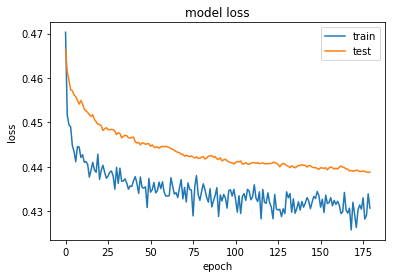

('avg auroc: ', 0.727785812246447)
('avg precision: ', 0.3377609108159393)
('avg recall: ', 0.6289752650176679)
('avg accuracy: ', 0.6997354497354498)
('avg specificity: ', 0.7160292921074044)
('avg f1: ', 0.4395061728395062)
('auroc: ', [0.727785812246447])
('precision: ', [0.3377609108159393])
('recall: ', [0.6289752650176679])
('accuracy: ', [0.6997354497354498])
('specificity: ', [0.7160292921074044])
('f1: ', [0.4395061728395062])
CPU times: user 48min 49s, sys: 4min 39s, total: 53min 28s
Wall time: 33min 2s


In [101]:
%%time
seed(1)
set_random_seed(2)
#10 100
# 8 60-70
# 6 57-65
# 4 350
auroc_list = []
precision_list = []
recall_list = []
accuracy_list = []
specificity_list = []
f1_list = []
for i in range(0,1):
    model = build_model(32, 0.1, 1, X_train_list[0][0].shape[0])
    history = fit_model(model, 180, X_train_list, y_train_list, X_test_list, y_test_list, verbose=1)
    y_predict = model.predict_generator(mygenerator(X_test_list), steps=len(X_test_list))
    y_predict = np.concatenate(y_predict)
    y_true = np.concatenate(y_test_list)
    auroc_list.append(auroc(y_predict, y_true))
    f1, th = find_best_f1(y_predict, y_true)
    f1_list.append(f1)
    precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    specificity_list.append(specificity)
print('avg auroc: ', np.mean(auroc_list))
print('avg precision: ', np.mean(precision_list))
print('avg recall: ', np.mean(recall_list))
print('avg accuracy: ', np.mean(accuracy_list))
print('avg specificity: ', np.mean(specificity_list))
print('avg f1: ', np.mean(f1_list));
print('auroc: ', auroc_list)
print('precision: ', precision_list)
print('recall: ', recall_list)
print('accuracy: ', accuracy_list)
print('specificity: ', specificity_list)
print('f1: ', f1_list);

unit: 8	epoch: 50	auroc_mean: 0.699555	auroc_std: 0.019156
unit: 8	epoch: 60	auroc_mean: 0.700691	auroc_std: 0.018938
unit: 8	epoch: 70	auroc_mean: 0.701370	auroc_std: 0.018729
unit: 8	epoch: 100	auroc_mean: 0.702887	auroc_std: 0.018197
unit: 8	epoch: 125	auroc_mean: 0.703563	auroc_std: 0.018108
unit: 8	epoch: 150	auroc_mean: 0.703994	auroc_std: 0.018072
unit: 8	epoch: 200	auroc_mean: 0.704332	auroc_std: 0.017631
unit: 8	epoch: 300	auroc_mean: 0.704859	auroc_std: 0.017847

unit: 16	epoch: 100	auroc_mean: 0.706576	auroc_std: 0.018529
unit: 25	epoch: 100	auroc_mean: 0.705890	auroc_std: 0.018846
unit: 30	epoch: 100	auroc_mean: 0.706146	auroc_std: 0.019411
unit: 32	epoch: 100	auroc_mean: 0.707448	auroc_std: 0.019337
unit: 32	epoch: 150	auroc_mean: 0.708563	auroc_std: 0.019562
unit: 40	epoch: 100	auroc_mean: 0.706949	auroc_std: 0.018761
unit: 50	epoch: 100	auroc_mean: 0.706192	auroc_std: 0.020768

unit: 32	epoch: 65	auroc_mean: 0.706663	auroc_std: 0.018844
unit: 32	epoch: 70	auroc_mean: 0.706855	auroc_std: 0.018997
unit: 32	epoch: 85	auroc_mean: 0.707206	auroc_std: 0.019241
unit: 32	epoch: 100	auroc_mean: 0.707448	auroc_std: 0.019337
unit: 32	epoch: 150	auroc_mean: 0.708563	auroc_std: 0.019562
unit: 32	epoch: 170	auroc_mean: 0.708822	auroc_std: 0.019401
unit: 32	epoch: 180	auroc_mean: 0.709108	auroc_std: 0.019497
unit: 32	epoch: 190	auroc_mean: 0.709048	auroc_std: 0.019752
unit: 32	epoch: 200	auroc_mean: 0.708935	auroc_std: 0.019949
unit: 32	epoch: 210	auroc_mean: 0.708586	auroc_std: 0.019831
unit: 32	epoch: 250	auroc_mean: 0.708529	auroc_std: 0.020297

unit: 50	epoch: 80	auroc_mean: 0.705207	auroc_std: 0.020670
unit: 50	epoch: 100	auroc_mean: 0.706192	auroc_std: 0.020768

Epoch 1/180
1754/1754 [==============================] - 15s 8ms/step - loss: 0.3810 - binary_accuracy: 0.8700 - val_loss: 0.4537 - val_binary_accuracy: 0.8156
Epoch 2/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3633 - binary_accuracy: 0.8706 - val_loss: 0.4464 - val_binary_accuracy: 0.8156
Epoch 3/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3668 - binary_accuracy: 0.8703 - val_loss: 0.4427 - val_binary_accuracy: 0.8156
Epoch 4/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3607 - binary_accuracy: 0.8701 - val_loss: 0.4405 - val_binary_accuracy: 0.8156
Epoch 5/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3626 - binary_accuracy: 0.8697 - val_loss: 0.4395 - val_binary_accuracy: 0.8156
Epoch 6/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3581 - binary_accuracy: 0.8700 - val_loss: 0.4386 - val_binary_accuracy: 0.8156
Epoch 7/180
1754/1754 [======================

1754/1754 [==============================] - 6s 3ms/step - loss: 0.3464 - binary_accuracy: 0.8699 - val_loss: 0.4296 - val_binary_accuracy: 0.8156
Epoch 53/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3460 - binary_accuracy: 0.8719 - val_loss: 0.4297 - val_binary_accuracy: 0.8156
Epoch 54/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3459 - binary_accuracy: 0.8704 - val_loss: 0.4298 - val_binary_accuracy: 0.8156
Epoch 55/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3483 - binary_accuracy: 0.8712 - val_loss: 0.4298 - val_binary_accuracy: 0.8156
Epoch 56/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3515 - binary_accuracy: 0.8715 - val_loss: 0.4298 - val_binary_accuracy: 0.8156
Epoch 57/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3462 - binary_accuracy: 0.8713 - val_loss: 0.4298 - val_binary_accuracy: 0.8156
Epoch 58/180
1754/1754 [=============================

1754/1754 [==============================] - 5s 3ms/step - loss: 0.3417 - binary_accuracy: 0.8713 - val_loss: 0.4290 - val_binary_accuracy: 0.8156
Epoch 104/180
1754/1754 [==============================] - 5s 3ms/step - loss: 0.3459 - binary_accuracy: 0.8718 - val_loss: 0.4290 - val_binary_accuracy: 0.8156
Epoch 105/180
1754/1754 [==============================] - 5s 3ms/step - loss: 0.3443 - binary_accuracy: 0.8709 - val_loss: 0.4289 - val_binary_accuracy: 0.8156
Epoch 106/180
1754/1754 [==============================] - 5s 3ms/step - loss: 0.3427 - binary_accuracy: 0.8727 - val_loss: 0.4289 - val_binary_accuracy: 0.8156
Epoch 107/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3435 - binary_accuracy: 0.8715 - val_loss: 0.4289 - val_binary_accuracy: 0.8156
Epoch 108/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3423 - binary_accuracy: 0.8716 - val_loss: 0.4289 - val_binary_accuracy: 0.8156
Epoch 109/180
1754/1754 [=======================

Epoch 154/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3434 - binary_accuracy: 0.8710 - val_loss: 0.4290 - val_binary_accuracy: 0.8156
Epoch 155/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3383 - binary_accuracy: 0.8730 - val_loss: 0.4291 - val_binary_accuracy: 0.8156
Epoch 156/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3439 - binary_accuracy: 0.8711 - val_loss: 0.4291 - val_binary_accuracy: 0.8166
Epoch 157/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3405 - binary_accuracy: 0.8721 - val_loss: 0.4293 - val_binary_accuracy: 0.8156
Epoch 158/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3406 - binary_accuracy: 0.8730 - val_loss: 0.4293 - val_binary_accuracy: 0.8166
Epoch 159/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3421 - binary_accuracy: 0.8722 - val_loss: 0.4293 - val_binary_accuracy: 0.8156
Epoch 160/180
1754/1754 [=========

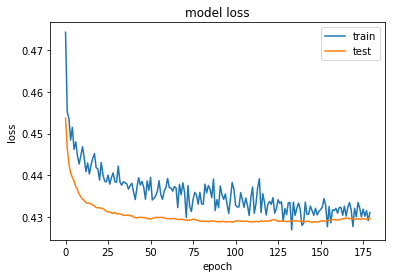

Epoch 1/180
1755/1755 [==============================] - 14s 8ms/step - loss: 0.3836 - binary_accuracy: 0.8688 - val_loss: 0.4611 - val_binary_accuracy: 0.8164
Epoch 2/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3647 - binary_accuracy: 0.8704 - val_loss: 0.4573 - val_binary_accuracy: 0.8164
Epoch 3/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3570 - binary_accuracy: 0.8704 - val_loss: 0.4547 - val_binary_accuracy: 0.8164
Epoch 4/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3595 - binary_accuracy: 0.8702 - val_loss: 0.4536 - val_binary_accuracy: 0.8173
Epoch 5/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3558 - binary_accuracy: 0.8703 - val_loss: 0.4532 - val_binary_accuracy: 0.8164
Epoch 6/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3526 - binary_accuracy: 0.8700 - val_loss: 0.4527 - val_binary_accuracy: 0.8164
Epoch 7/180
1755/1755 [======================

1755/1755 [==============================] - 6s 3ms/step - loss: 0.3473 - binary_accuracy: 0.8689 - val_loss: 0.4463 - val_binary_accuracy: 0.8277
Epoch 53/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3456 - binary_accuracy: 0.8714 - val_loss: 0.4463 - val_binary_accuracy: 0.8277
Epoch 54/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3438 - binary_accuracy: 0.8718 - val_loss: 0.4464 - val_binary_accuracy: 0.8277
Epoch 55/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3443 - binary_accuracy: 0.8712 - val_loss: 0.4463 - val_binary_accuracy: 0.8277
Epoch 56/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3432 - binary_accuracy: 0.8713 - val_loss: 0.4462 - val_binary_accuracy: 0.8286
Epoch 57/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3397 - binary_accuracy: 0.8705 - val_loss: 0.4468 - val_binary_accuracy: 0.8296
Epoch 58/180
1755/1755 [=============================

1755/1755 [==============================] - 6s 4ms/step - loss: 0.3395 - binary_accuracy: 0.8710 - val_loss: 0.4460 - val_binary_accuracy: 0.8277
Epoch 104/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3388 - binary_accuracy: 0.8702 - val_loss: 0.4460 - val_binary_accuracy: 0.8277
Epoch 105/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3395 - binary_accuracy: 0.8714 - val_loss: 0.4459 - val_binary_accuracy: 0.8277
Epoch 106/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3416 - binary_accuracy: 0.8707 - val_loss: 0.4459 - val_binary_accuracy: 0.8277
Epoch 107/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3386 - binary_accuracy: 0.8713 - val_loss: 0.4458 - val_binary_accuracy: 0.8277
Epoch 108/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3379 - binary_accuracy: 0.8713 - val_loss: 0.4460 - val_binary_accuracy: 0.8277
Epoch 109/180
1755/1755 [=======================

Epoch 154/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3360 - binary_accuracy: 0.8726 - val_loss: 0.4457 - val_binary_accuracy: 0.8267
Epoch 155/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3337 - binary_accuracy: 0.8708 - val_loss: 0.4458 - val_binary_accuracy: 0.8258
Epoch 156/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3395 - binary_accuracy: 0.8708 - val_loss: 0.4458 - val_binary_accuracy: 0.8258
Epoch 157/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3399 - binary_accuracy: 0.8727 - val_loss: 0.4457 - val_binary_accuracy: 0.8258
Epoch 158/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3397 - binary_accuracy: 0.8713 - val_loss: 0.4456 - val_binary_accuracy: 0.8258
Epoch 159/180
1755/1755 [==============================] - 6s 4ms/step - loss: 0.3332 - binary_accuracy: 0.8728 - val_loss: 0.4456 - val_binary_accuracy: 0.8258
Epoch 160/180
1755/1755 [=========

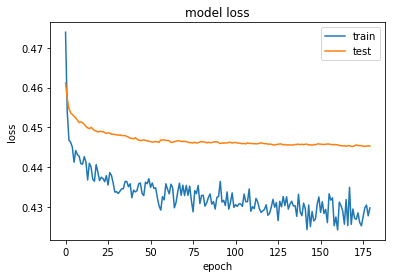

Epoch 1/180
1755/1755 [==============================] - 14s 8ms/step - loss: 0.3713 - binary_accuracy: 0.8754 - val_loss: 0.4790 - val_binary_accuracy: 0.8051
Epoch 2/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3540 - binary_accuracy: 0.8758 - val_loss: 0.4708 - val_binary_accuracy: 0.8051
Epoch 3/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3505 - binary_accuracy: 0.8759 - val_loss: 0.4678 - val_binary_accuracy: 0.8051
Epoch 4/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3460 - binary_accuracy: 0.8763 - val_loss: 0.4662 - val_binary_accuracy: 0.8051
Epoch 5/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3439 - binary_accuracy: 0.8760 - val_loss: 0.4650 - val_binary_accuracy: 0.8051
Epoch 6/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3470 - binary_accuracy: 0.8766 - val_loss: 0.4631 - val_binary_accuracy: 0.8032
Epoch 7/180
1755/1755 [======================

1755/1755 [==============================] - 6s 3ms/step - loss: 0.3345 - binary_accuracy: 0.8779 - val_loss: 0.4591 - val_binary_accuracy: 0.8023
Epoch 53/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3344 - binary_accuracy: 0.8774 - val_loss: 0.4591 - val_binary_accuracy: 0.8013
Epoch 54/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3372 - binary_accuracy: 0.8770 - val_loss: 0.4589 - val_binary_accuracy: 0.8013
Epoch 55/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3361 - binary_accuracy: 0.8782 - val_loss: 0.4587 - val_binary_accuracy: 0.8013
Epoch 56/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3357 - binary_accuracy: 0.8762 - val_loss: 0.4589 - val_binary_accuracy: 0.8013
Epoch 57/180
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3317 - binary_accuracy: 0.8764 - val_loss: 0.4591 - val_binary_accuracy: 0.8013
Epoch 58/180
1755/1755 [=============================

1755/1755 [==============================] - 5s 3ms/step - loss: 0.3306 - binary_accuracy: 0.8765 - val_loss: 0.4582 - val_binary_accuracy: 0.8004
Epoch 104/180
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3318 - binary_accuracy: 0.8774 - val_loss: 0.4582 - val_binary_accuracy: 0.8004
Epoch 105/180
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3277 - binary_accuracy: 0.8783 - val_loss: 0.4584 - val_binary_accuracy: 0.8004
Epoch 106/180
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3293 - binary_accuracy: 0.8783 - val_loss: 0.4586 - val_binary_accuracy: 0.8004
Epoch 107/180
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3290 - binary_accuracy: 0.8784 - val_loss: 0.4585 - val_binary_accuracy: 0.8004
Epoch 108/180
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3296 - binary_accuracy: 0.8754 - val_loss: 0.4586 - val_binary_accuracy: 0.8004
Epoch 109/180
1755/1755 [=======================

Epoch 154/180
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3239 - binary_accuracy: 0.8784 - val_loss: 0.4588 - val_binary_accuracy: 0.8004
Epoch 155/180
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3279 - binary_accuracy: 0.8774 - val_loss: 0.4586 - val_binary_accuracy: 0.8004
Epoch 156/180
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3303 - binary_accuracy: 0.8775 - val_loss: 0.4583 - val_binary_accuracy: 0.8004
Epoch 157/180
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3316 - binary_accuracy: 0.8773 - val_loss: 0.4580 - val_binary_accuracy: 0.8004
Epoch 158/180
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3265 - binary_accuracy: 0.8776 - val_loss: 0.4581 - val_binary_accuracy: 0.8004
Epoch 159/180
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3269 - binary_accuracy: 0.8769 - val_loss: 0.4583 - val_binary_accuracy: 0.8004
Epoch 160/180
1755/1755 [=========

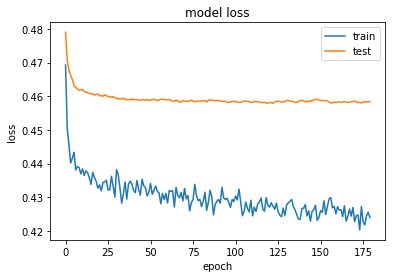

Epoch 1/180
1754/1754 [==============================] - 15s 8ms/step - loss: 0.3885 - binary_accuracy: 0.8673 - val_loss: 0.4558 - val_binary_accuracy: 0.8136
Epoch 2/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3719 - binary_accuracy: 0.8677 - val_loss: 0.4461 - val_binary_accuracy: 0.8136
Epoch 3/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3707 - binary_accuracy: 0.8677 - val_loss: 0.4415 - val_binary_accuracy: 0.8136
Epoch 4/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3672 - binary_accuracy: 0.8678 - val_loss: 0.4393 - val_binary_accuracy: 0.8136
Epoch 5/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3631 - binary_accuracy: 0.8679 - val_loss: 0.4378 - val_binary_accuracy: 0.8136
Epoch 6/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3655 - binary_accuracy: 0.8678 - val_loss: 0.4363 - val_binary_accuracy: 0.8136
Epoch 7/180
1754/1754 [======================

1754/1754 [==============================] - 7s 4ms/step - loss: 0.3532 - binary_accuracy: 0.8688 - val_loss: 0.4276 - val_binary_accuracy: 0.8126
Epoch 53/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3525 - binary_accuracy: 0.8681 - val_loss: 0.4275 - val_binary_accuracy: 0.8126
Epoch 54/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3528 - binary_accuracy: 0.8678 - val_loss: 0.4277 - val_binary_accuracy: 0.8126
Epoch 55/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3547 - binary_accuracy: 0.8687 - val_loss: 0.4275 - val_binary_accuracy: 0.8126
Epoch 56/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3510 - binary_accuracy: 0.8684 - val_loss: 0.4275 - val_binary_accuracy: 0.8126
Epoch 57/180
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3500 - binary_accuracy: 0.8695 - val_loss: 0.4275 - val_binary_accuracy: 0.8126
Epoch 58/180
1754/1754 [=============================

1754/1754 [==============================] - 5s 3ms/step - loss: 0.3461 - binary_accuracy: 0.8678 - val_loss: 0.4261 - val_binary_accuracy: 0.8154
Epoch 104/180
1754/1754 [==============================] - 5s 3ms/step - loss: 0.3468 - binary_accuracy: 0.8689 - val_loss: 0.4261 - val_binary_accuracy: 0.8145
Epoch 105/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3513 - binary_accuracy: 0.8679 - val_loss: 0.4262 - val_binary_accuracy: 0.8154
Epoch 106/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3494 - binary_accuracy: 0.8681 - val_loss: 0.4262 - val_binary_accuracy: 0.8145
Epoch 107/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3513 - binary_accuracy: 0.8692 - val_loss: 0.4262 - val_binary_accuracy: 0.8164
Epoch 108/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3467 - binary_accuracy: 0.8697 - val_loss: 0.4261 - val_binary_accuracy: 0.8154
Epoch 109/180
1754/1754 [=======================

Epoch 154/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3446 - binary_accuracy: 0.8685 - val_loss: 0.4251 - val_binary_accuracy: 0.8136
Epoch 155/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3511 - binary_accuracy: 0.8697 - val_loss: 0.4250 - val_binary_accuracy: 0.8136
Epoch 156/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3450 - binary_accuracy: 0.8672 - val_loss: 0.4251 - val_binary_accuracy: 0.8136
Epoch 157/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3431 - binary_accuracy: 0.8694 - val_loss: 0.4251 - val_binary_accuracy: 0.8136
Epoch 158/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3479 - binary_accuracy: 0.8683 - val_loss: 0.4250 - val_binary_accuracy: 0.8145
Epoch 159/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3448 - binary_accuracy: 0.8683 - val_loss: 0.4250 - val_binary_accuracy: 0.8136
Epoch 160/180
1754/1754 [=========

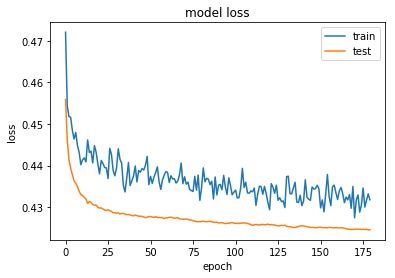

Epoch 1/180
1754/1754 [==============================] - 15s 8ms/step - loss: 0.3755 - binary_accuracy: 0.8697 - val_loss: 0.4381 - val_binary_accuracy: 0.8286
Epoch 2/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3653 - binary_accuracy: 0.8708 - val_loss: 0.4325 - val_binary_accuracy: 0.8286
Epoch 3/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3593 - binary_accuracy: 0.8708 - val_loss: 0.4312 - val_binary_accuracy: 0.8286
Epoch 4/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3571 - binary_accuracy: 0.8715 - val_loss: 0.4289 - val_binary_accuracy: 0.8296
Epoch 5/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3531 - binary_accuracy: 0.8709 - val_loss: 0.4283 - val_binary_accuracy: 0.8296
Epoch 6/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3549 - binary_accuracy: 0.8696 - val_loss: 0.4272 - val_binary_accuracy: 0.8296
Epoch 7/180
1754/1754 [======================

1754/1754 [==============================] - 6s 4ms/step - loss: 0.3451 - binary_accuracy: 0.8714 - val_loss: 0.4228 - val_binary_accuracy: 0.8286
Epoch 53/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3429 - binary_accuracy: 0.8728 - val_loss: 0.4227 - val_binary_accuracy: 0.8286
Epoch 54/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3434 - binary_accuracy: 0.8727 - val_loss: 0.4228 - val_binary_accuracy: 0.8286
Epoch 55/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3413 - binary_accuracy: 0.8712 - val_loss: 0.4228 - val_binary_accuracy: 0.8286
Epoch 56/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3441 - binary_accuracy: 0.8701 - val_loss: 0.4228 - val_binary_accuracy: 0.8286
Epoch 57/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3381 - binary_accuracy: 0.8721 - val_loss: 0.4229 - val_binary_accuracy: 0.8286
Epoch 58/180
1754/1754 [=============================

1754/1754 [==============================] - 6s 3ms/step - loss: 0.3402 - binary_accuracy: 0.8725 - val_loss: 0.4231 - val_binary_accuracy: 0.8277
Epoch 104/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3368 - binary_accuracy: 0.8728 - val_loss: 0.4231 - val_binary_accuracy: 0.8277
Epoch 105/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3333 - binary_accuracy: 0.8730 - val_loss: 0.4232 - val_binary_accuracy: 0.8286
Epoch 106/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3391 - binary_accuracy: 0.8705 - val_loss: 0.4231 - val_binary_accuracy: 0.8277
Epoch 107/180
1754/1754 [==============================] - 6s 3ms/step - loss: 0.3392 - binary_accuracy: 0.8723 - val_loss: 0.4230 - val_binary_accuracy: 0.8286
Epoch 108/180
1754/1754 [==============================] - 6s 4ms/step - loss: 0.3385 - binary_accuracy: 0.8723 - val_loss: 0.4231 - val_binary_accuracy: 0.8286
Epoch 109/180
1754/1754 [=======================

Epoch 154/180
1754/1754 [==============================] - 8s 5ms/step - loss: 0.3353 - binary_accuracy: 0.8750 - val_loss: 0.4232 - val_binary_accuracy: 0.8267
Epoch 155/180
1754/1754 [==============================] - 9s 5ms/step - loss: 0.3350 - binary_accuracy: 0.8704 - val_loss: 0.4233 - val_binary_accuracy: 0.8267
Epoch 156/180
1754/1754 [==============================] - 9s 5ms/step - loss: 0.3328 - binary_accuracy: 0.8738 - val_loss: 0.4234 - val_binary_accuracy: 0.8267
Epoch 157/180
1754/1754 [==============================] - 9s 5ms/step - loss: 0.3357 - binary_accuracy: 0.8740 - val_loss: 0.4235 - val_binary_accuracy: 0.8267
Epoch 158/180
1754/1754 [==============================] - 9s 5ms/step - loss: 0.3325 - binary_accuracy: 0.8729 - val_loss: 0.4235 - val_binary_accuracy: 0.8267
Epoch 159/180
1754/1754 [==============================] - 8s 5ms/step - loss: 0.3393 - binary_accuracy: 0.8744 - val_loss: 0.4235 - val_binary_accuracy: 0.8258
Epoch 160/180
1754/1754 [=========

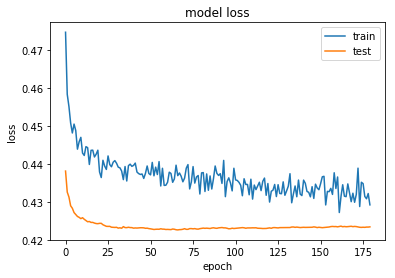

unit: 32	epoch: 180	auroc_mean: 0.709128	auroc_std: 0.019515
CPU times: user 2h 54min 31s, sys: 21min 15s, total: 3h 15min 46s
Wall time: 1h 31min 39s


In [100]:
%%time
ratio = 0.5
result = []
pdic = [(32, [180])]
for unit, epoch_list in pdic:
    for epoch in epoch_list:
        auroc_list = kfold_validation(unit, ratio, epoch, X_train_transformed, y_train, 'patient-id', verbose=1)
        result.append((unit, epoch, auroc_list))
        print("unit: %d\tepoch: %d\tauroc_mean: %f\tauroc_std: %f"  % (unit, epoch, np.mean(auroc_list), np.std(auroc_list)))

In [102]:
# 32 180 recurrent dropout 0.5
print('avg auroc:', np.mean(auroc_list))
print('avg precision:', np.mean(precision_list))
print('avg recall:', np.mean(recall_list))
print('avg accuracy:', np.mean(accuracy_list))
print('avg specificity:', np.mean(specificity_list))
print('avg f1:', np.mean(f1_list));
print('auroc:', auroc_list)
print('precision:', precision_list)
print('recall:', recall_list)
print('accuracy:', accuracy_list)
print('specificity:', specificity_list)
print('f1:', f1_list);
train_loss_h = deepcopy(history.history['loss'])
test_loss_h = deepcopy(history.history['val_loss'])

('avg auroc:', 0.727785812246447)
('avg precision:', 0.3377609108159393)
('avg recall:', 0.6289752650176679)
('avg accuracy:', 0.6997354497354498)
('avg specificity:', 0.7160292921074044)
('avg f1:', 0.4395061728395062)
('auroc:', [0.727785812246447])
('precision:', [0.3377609108159393])
('recall:', [0.6289752650176679])
('accuracy:', [0.6997354497354498])
('specificity:', [0.7160292921074044])
('f1:', [0.4395061728395062])


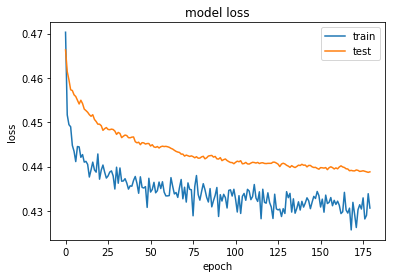

In [103]:
plot_history(history=None, loss=train_loss, val_loss=test_loss)